In [1]:
# Ion Chemistry

In [2]:
"""
Preparation (could be written as module)
- load file with reaction and species information, inkl. stochiometry and charges etc.
- produce classes with sepcies concentration etc
- produce classes with reaction information
"""

import numpy as np
from scipy.interpolate import CubicSpline, interp1d

printing = 0


class constituent():
    """
    For every constituent of the ionosphere, this class is generated to record its
    -density
    -production
    -loss
    and from that calculate the density of the new timestep.
    All these values are in the form of an array as a height profile.    
    """
    def __init__(self, c_ID, name, density):
        self.c_ID = int(c_ID)
        self.name = name
        self.density = density
        self.loss = np.zeros(len(density))
        self.prod = np.zeros(len(density))
        self.dndt = np.zeros(len(density))
    
    def log(self, density):
        raise NotImplementedError
        
    def integrate(self, prod, loss):
        self.dndt = prod - loss
        return NotImplementedError
    
    def iterate_time(self, dt):
        self.dndt = self.prod - self.loss
        self.density = self.density + self.dndt * dt
        self.density[self.density < 0] = 0
        #self.log(density)


class reaction():
    """
    Defines all parameters of a chemical reaction in the ionosphere
    
    Parameters:
    r_ID: Name of the reaction (according to Brekke of Schunk and Nagy)
        string
    r_stoch: Reaction in chemical symbols, with stochiometry
        string
    educts: constituents that go into the reaction (lefthand side of r_stoch)
        list of strings
    products: constituents that come out of the reaction (righthand side of r_stoch)
        list of strings
    r_rate_string: the reaction rate, ready to be interpreted as a equation in python (with variables)
        string
        
    Methods:
    r_rate: evaluates the reaction rate at a given temperature T
        float
    """
    def __init__(self, r_ID, r_stoch, educts, products, r_rate_string):
        self.r_ID = r_ID
        self.r_stoch = r_stoch
        self.educts = educts
        self.educts_ID = getConstituentsIDByName(self.educts)
        self.products = products
        self.products_ID = getConstituentsIDByName(self.products)
        self.r_rate_string = r_rate_string
        
    def r_rate(self, T):
        Te = T
        Tr = T
        self.rr = eval(self.r_rate_string)
        return self.rr
    

def getConstituentsIDByName(names):
    ids = np.array([], dtype = int)
    for name in names:
        for c in all_species:
            if c.name == name: ids = np.append(ids, c.c_ID)
    return ids

reactions_file = '/Users/ost051/Documents/PhD/Electron Precipitation/example/Meta-data/Reaction rates.txt'

species_raw = np.array([], dtype = object)
reactions_raw = np.array([], dtype = str)
with open(reactions_file, 'r') as f:
    content = f.read()
    lines = [line for line in content.split('\n')]
    for line_no, line in enumerate(lines):
        if line[:14] == '--Constituents':
            start_consprint = line_no
        if line[:11] == '--Reactions':
            start_reactions = line_no
            
    for line_no, line in enumerate(lines):
        if line_no > start_consprint+1 and line == '': break
        if line_no > start_consprint+1:
            species_raw = np.append(species_raw, line)

    for line_no, line in enumerate(lines):
        if line_no > start_reactions+1 and line == '': break
        if line_no > start_reactions+1:
            reactions_raw = np.append(reactions_raw, line)
    
species_str = np.array([c.replace('\t', '').replace(' ', '').split(';') for c in species_raw])
if printing: print(species_str, '\n')


reactions_str = np.array([r.replace('\t', '').split(';') for r in reactions_raw], dtype = object)
if printing: print(reactions_raw)
if printing: print(reactions_str)

all_species = []
for c in species_str:
    all_species.append(constituent(c[1], c[0], np.zeros(1300)))
    
for ind, c in enumerate(all_species):
    if printing: print(c.name, c.c_ID)
    if c.c_ID != ind: raise RuntimeError

all_reactions = []
"""
arrays:
axis 0: reactions
axis 1: ID, reaction rate, educts,     products
axis 2:                    e1, ...     p1, p2, ...
"""
for r in reactions_str:
    r_ID = r[0]
    r_rate_string = r[2].replace('m3s-1', '').replace(' ', '')
    r_stoch = r[1][1:]
    
    educts, products = r[1].split('=>')
    educts = educts.split(' + ')
    educts = np.char.replace(educts, ' ', '')

    products = products.split(' + ')
    products = np.char.replace(products, ' ', '')
    if printing: print(r_ID, r_rate_string, educts, products)
    
    all_reactions.append(reaction(r_ID, r_stoch, educts, products, r_rate_string))

if printing:
    Te = 300
    for i in all_reactions:
        print(i.r_ID)
        print(i.r_stoch)
        print(i.educts_ID, i.products_ID)
        for j in i.educts: print(j)
        print(i.r_rate(300))
        print('\n')
            

        

[['e' '0' '-1']
 ['O' '1' '0']
 ['O+' '2' '1']
 ['O2' '3' '0']
 ['O2+' '4' '1']
 ['N' '5' '0']
 ['N+' '6' '1']
 ['N2' '7' '0']
 ['N2+' '8' '1']
 ['NO' '9' '0']
 ['NO+' '10' '1']] 

['alpha1\t; NO+ + e => N + O\t; 4.0e-13*(300/Te)**(0.5) m3s-1\t; SN\t\t; quite different from B, follow up?'
 'alpha2\t; O2+ + e => O + O\t; 2.4e-13*(300/Te)**(0.70) m3s-1; SN\t\t; '
 'alpha3  ; N2+ + e => N + N\t; 2.2e-13*(300/Te)**(0.39) m3s-1; SN\t\t;'
 'k1\t; O+  + N2  => NO+ + N\t; 5e-19 m3s-1\t\t\t; R\t\t; still no temperature dependence'
 'k1c\t; O+  + N2  => N+  + NO\t; 1e-16 m3s-1\t\t\t; R\t\t; seems to be a considerable reaction path; just include it and see the build-up (also as a test)'
 'k1b\t; O+  + N2  => N2+ + O\t; 4.8e-16+8e-16 m3s-1\t\t; R\t\t; 2 different reaction speeds for O+(2P) and O+(2D)'
 'k2\t; O+  + O2  => O2+ + O\t; 7e-16+2e-17*(300/Tr)**(0.4)\t; R\t\t; 2 different reaction speeds for O+(4S) and O+(2D)'
 'k3\t; O2+ + NO  => NO+ + O2\t; 4.6e-16 m3s-1\t\t\t; SN, R\t\t; both sources 

In [39]:
if printing: import matplotlib.pyplot as plt
def assign_densities(z_model
                     , z_msis
                     , n_o1_msis
                     , n_n2_msis
                     , n_o2_msis
                     , z_iri
                     , ne_iri        
                     , rel_o_p   
                     , rel_n_p   
                     , rel_h_p   
                     , rel_he_p  
                     , rel_o2_p  
                     , rel_no_p):
    
    print(all_species[0].name)
    all_species[0].density = np.exp(interp1d(z_iri[1:], np.log(ne_iri[1:]), fill_value = 'extrapolate')(z_model))
    if printing:
        plt.figure()
        #plt.plot(alt_dens, z_model/1e3, label = 'interp_old')
        #plt.plot(, z_msis/1e3, label = 'MSIS data', marker = 'x')
        plt.plot(all_species[0].density, z_model/1e3, label = 'ne_iri (?)')
        plt.xscale('log')
        plt.xlabel('Density [m-3]')
        plt.ylabel('Altitude [km]')
        plt.title('Density profiles of e')
        plt.legend()
    
    all_species[1].density = np.exp(CubicSpline(z_msis, np.log(n_o1_msis))(z_model))
    if printing:
        plt.figure()
        #plt.plot(alt_dens, z_model/1e3, label = 'interp_old')
        plt.plot(n_o1_msis, z_msis/1e3, label = 'MSIS data', marker = 'x')
        plt.plot(all_species[1].density, z_model/1e3, label = 'interp')
        plt.xscale('log')
        plt.xlabel('Density [m-3]')
        plt.ylabel('Altitude [km]')
        plt.title('Density profiles of O &' + all_species[1].name)
        plt.legend()
        
    print(all_species[2].name)
    all_species[2].density = all_species[0].density*interp1d(z_iri, rel_o_p, fill_value='extrapolate')(z_model)
    if printing:
        plt.figure()
        #plt.plot(alt_dens, z_model/1e3, label = 'interp_old')
        plt.plot(rel_o_p, z_iri/1e3, label = 'IRI data', marker = 'x')
        plt.plot(all_species[2].density/all_species[0].density, z_model/1e3, label = 'interp')
        plt.xscale('log')
        plt.xlabel('Density [m-3]')
        plt.ylabel('Altitude [km]')
        plt.title('Density profiles of O+')
        plt.legend()
    
    print(all_species[3].name)
    all_species[3].density = CubicSpline(z_msis, n_o2_msis)(z_model)
    if printing:
        plt.figure()
        #plt.plot(alt_dens, z_model/1e3, label = 'interp_old')
        plt.plot(n_o2_msis, z_msis/1e3, label = 'MSIS data', marker = 'x')
        plt.plot(all_species[3].density, z_model/1e3, label = 'interp')
        plt.xscale('log')
        plt.xlabel('Density [m-3]')
        plt.ylabel('Altitude [km]')
        plt.title('Density profiles of O2')
        plt.legend()
        
    print(all_species[4].name)
    #all_species[4].density = all_species[0].density*CubicSpline(z_iri, rel_o2_p)(z_model)
    all_species[4].density = all_species[0].density*np.exp(interp1d(z_iri, np.log(rel_o2_p), fill_value='extrapolate')(z_model))
    if printing:
        plt.figure()
        #plt.plot(alt_dens, z_model/1e3, label = 'interp_old')
        plt.plot(rel_o2_p, z_iri/1e3, label = 'IRI data', marker = 'x')
        plt.plot(all_species[4].density/all_species[0].density, z_model/1e3, label = 'interp')
        plt.xscale('log')
        plt.xlabel('Density [m-3]')
        plt.ylabel('Altitude [km]')
        plt.title('Density profiles of O2+')
        plt.legend()
    
    print(all_species[5].name)
    all_species[5].density = all_species[0].density*0
    
    print(all_species[6].name)
    all_species[6].density = all_species[0].density*0
    
    print(all_species[7].name)
    all_species[7].density = CubicSpline(z_msis, n_n2_msis)(z_model)
    if printing:
        plt.figure()
        #plt.plot(alt_dens, z_model/1e3, label = 'interp_old')
        plt.plot(n_n2_msis, z_msis/1e3, label = 'MSIS data', marker = 'x')
        plt.plot(all_species[7].density, z_model/1e3, label = 'interp')
        plt.xscale('log')
        plt.xlabel('Density [m-3]')
        plt.ylabel('Altitude [km]')
        plt.title('Density profiles of N2')
        plt.legend()
    
    print(all_species[8].name)
    all_species[8].density = all_species[0].density*0
    
    print(all_species[9].name)
    all_species[9].density = all_species[0].density*0
    
    print(all_species[10].name)
    #all_species[10].density = all_species[0].density*CubicSpline(z_iri, rel_no_p)(z_model)
    all_species[10].density = all_species[0].density*np.exp(interp1d(z_iri, np.log(rel_no_p), fill_value='extrapolate')(z_model))
    if printing:
        plt.figure()
        #plt.plot(alt_dens, z_model/1e3, label = 'interp_old')
        plt.plot(rel_no_p, z_iri/1e3, label = 'IRI data', marker = 'x')
        plt.plot(all_species[10].density/all_species[0].density, z_model/1e3, label = 'interp')
        plt.xscale('log')
        plt.xlabel('Density [m-3]')
        plt.ylabel('Altitude [km]')
        plt.title('Density profiles of NO+')
        plt.legend()

In [40]:
__all__ = ['all_species', 'all_reactions', 'getConstituentsIDByName', 'constituent', 'reaction', 'assign_densities']


e
O+
O2
O2+
N
N+
N2
N2+
NO
NO+


/var/folders/gg/y13kmxq903n_0k8qcq3bqf4r0000gp/T/ipykernel_79901/3560313003.py:69: RuntimeWarning: divide by zero encountered in log
  all_species[4].density = all_species[0].density*np.exp(interp1d(z_iri, np.log(rel_o2_p), fill_value='extrapolate')(z_model))
/var/folders/gg/y13kmxq903n_0k8qcq3bqf4r0000gp/T/ipykernel_79901/3560313003.py:108: RuntimeWarning: divide by zero encountered in log
  all_species[10].density = all_species[0].density*np.exp(interp1d(z_iri, np.log(rel_no_p), fill_value='extrapolate')(z_model))


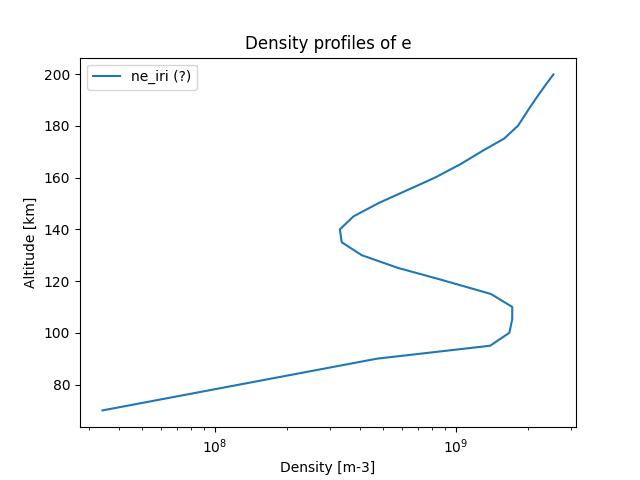

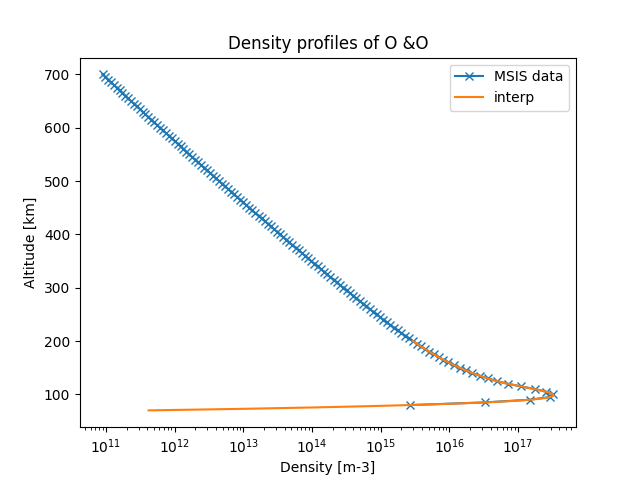

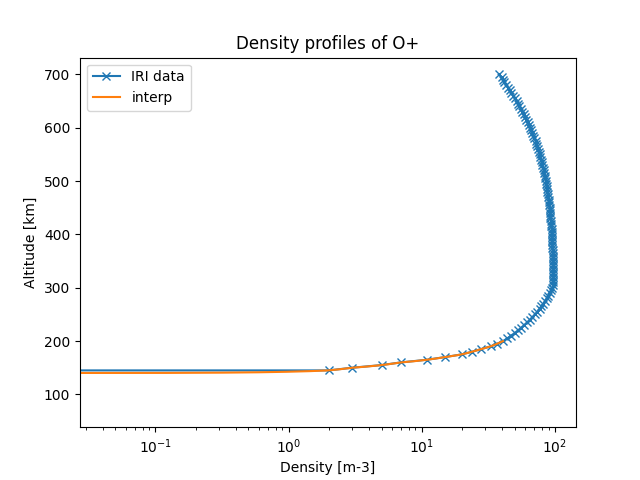

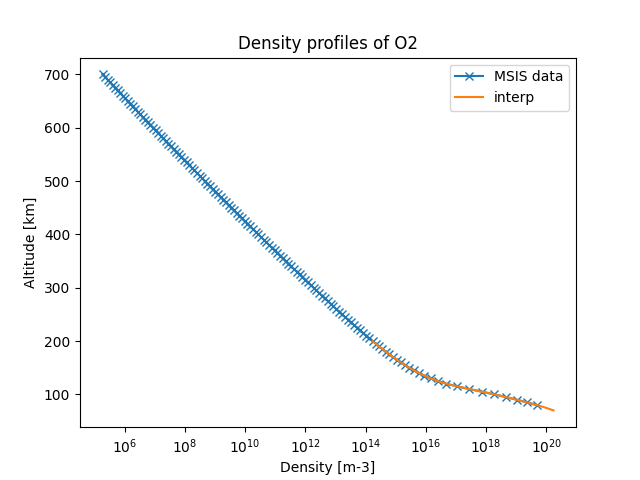

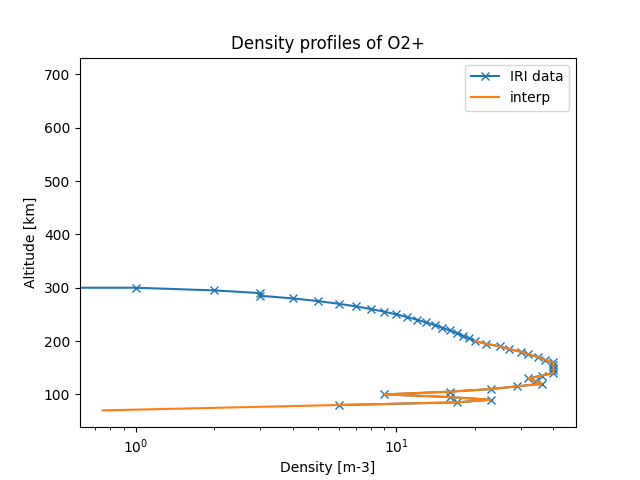

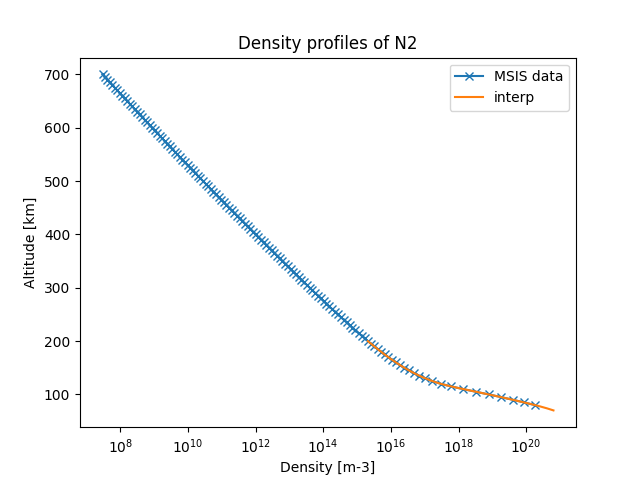

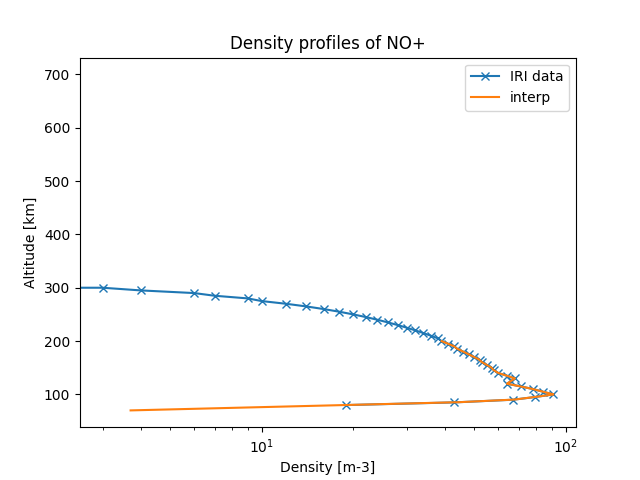

In [42]:
if printing:
    import numpy as np
    import import_ipynb
    
    import organizing
    import loadMSIS
    import loadIRI
    import EnergyDissipation 
    import loadEISCAT
    %matplotlib widget
    
    '''
    This is the main file. It is used to start the simulation.
    Configuration files from IRI and MSIS models are specified here.
    Eiscat data files are specified here.
    '''
    
    msis_config = '/Users/ost051/Documents/PhD/Electron Precipitation/example/Meta-data/msis.txt'
    iri_config  = '/Users/ost051/Documents/PhD/Electron Precipitation/example/Meta-data/iri.txt'
    chemistry_config = '/Users/ost051/Documents/PhD/Electron Precipitation/example/Meta-data/Reaction rates.txt'
    path_eiscat_data = '/Users/ost051/Documents/PhD/Electron Precipitation/example/Data/'
    
    setup_ = organizing.setup(msis_config, iri_config, chemistry_config, path_eiscat_data)
    log_directory = setup_._log_directory
    
    [z_msis
     , n_o1_msis
     , n_n2_msis
     , n_o2_msis
     , mass_density
     , temp_n_msis
     , scale_height_msis] = loadMSIS.loadMSIS(log_directory + '/Config/msis.txt')
    
    [z_iri     
     , ne_iri    
     , t_neutral 
     , t_ion     
     , t_e       
     , rel_o_p   
     , rel_n_p   
     , rel_h_p   
     , rel_he_p  
     , rel_o2_p  
     , rel_no_p] = loadIRI.loadIRI(log_directory + '/Config/iri.txt')
    
    z_model = np.arange(70000, 200000, 100)
    
    assign_densities(z_model
                         , z_msis
                         , n_o1_msis
                         , n_n2_msis
                         , n_o2_msis
                         , z_iri
                         , ne_iri        
                         , rel_o_p   
                         , rel_n_p   
                         , rel_h_p   
                         , rel_he_p  
                         , rel_o2_p  
                         , rel_no_p)